In [7]:
# Common useful packages
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import spectral

# Scripts associated with the SML4SI textbook
import hyperspectral_gta_data as hsi_data
import scripts_M2 as sm2

from sklearn import cluster, datasets, mixture, metrics
from itertools import cycle, islice

In [9]:
def original_image(fname):
    im = spectral.envi.open(fname+'.hdr', fname)
    wl = np.asarray(im.bands.centers)
    imArr = im.load()
    imList = np.reshape(imArr, (im.nrows*im.ncols, im.nbands))
    return wl, im, imList

In [11]:
def ground_truth(fname):
    # load the associated ground truth image
    file1 = open(fname, 'r')
    Lines = file1.readlines()

    # Strips the newline character
    groundtruth_classes = {}
    class_names = []

    classIndex = 0
    idx = 0
    x = 0
    for line in Lines:
        
        if line[0]==';':
            line = line.strip()
            #  reading the header info
            if line[:11] == '; ROI name:':
                name = line[12:]
                class_names.append(name)
                groundtruth_classes[name] = {'classIndex': classIndex, 'locations': []}
                classIndex = classIndex + 1
            if line[:11] == 'ROI npts:':
                groundtruth_classes[name]['npts'] = float(line[12:])
                
        else:
            line = line.strip()
            # reading the data
            if len(line)==0:
                # blank line - swtch to next class (aka ROI)
                idx = idx + 1
            else:
                loc = line.split(' ') # read the locations, split by spaces
                loc = [i for i in loc if i != '']  # remove blank spaces
                loc = [loc[2],loc[1]] # get the x and y coords
                groundtruth_classes[class_names[idx]]['locations'].append(loc)

    # Iterate throught the classes and color the ground truth image for each pixel in the ground truth:
    gt_im = np.zeros((im.nrows,im.ncols))
    for key in groundtruth_classes.keys():
        #print(f'Name: {key}')
        idx = groundtruth_classes[key]['classIndex']
        #print(f'Index: {idx}')
        locations = groundtruth_classes[key]['locations'] #pull out x and y values
        #print(f'Number of points: {len(locations)}')
        #print(' ')
        for x,y in locations:
            gt_im[int(x),int(y)] = int(idx)

    gt_list = np.reshape(gt_im, (im.nrows*im.ncols))

    return gt_list

In [15]:
images = [('DC'
           ,'../spectral_images/WashingtonDC_Ref_156bands/WashingtonDC_Ref_156bands'
           ,'../spectral_images/WashingtonDC_groundTruth/WashDCclassLocations.txt'),
           ('Polymer'
           ,'../spectral_images/Microscene_Polymers/reflectance_image_polymers'
           ,'../spectral_images/Microscene_Polymers_groundTruth/reflectance_image_polymers_surfaces.txt')]

#Instantiate empty lists
image = []
alg_list = []
amis_var = []
ars_var = []
plot_num = 1

#Define Clustering Algorithms
two_means = cluster.MiniBatchKMeans(n_clusters=8,random_state=0)
affinity_propagation = cluster.AffinityPropagation(random_state=0)
ms = cluster.MeanShift(bin_seeding=True)
spectral_cluster = cluster.SpectralClustering(n_clusters=8,random_state=0)
ward = cluster.AgglomerativeClustering(n_clusters=8, linkage="ward")
average_linkage = cluster.AgglomerativeClustering(n_clusters=8)
dbscan = cluster.DBSCAN(eps=3, min_samples=10)
hdbscan = cluster.HDBSCAN()
optics = cluster.OPTICS()
birch = cluster.Birch(n_clusters=8)
gmm = mixture.GaussianMixture(n_components=8,random_state=0)

#with imList[:2,:2]
clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means), #works on DC and Polymer (around 2 seconds)
        #("Affinity\nPropagation", affinity_propagation), #over 5 min on DC, kernal died on Polymer
        #("MeanShift", ms),#over 5 min on DC and Polymer
        #("Spectral\nClustering", spectral_cluster), #over 5 min on DC, kernal died on Polymer
        #("Ward", ward), #kernel died on DC, over 6 min on Polymer
        #("Agglomerative\nClustering", average_linkage), #over 5 min on DC and Polymer
        #("DBSCAN", dbscan), #works on DC (around 20 seconds), kernal died on Polymer
        #("HDBSCAN", hdbscan), #works on DC (5 min 17 sec) and Polymer (4 min 8 sec)
        #("OPTICS", optics), #over 6 min on DC and Polymer
        #("BIRCH", birch), ##kernel died on DC, works on Polymer (ran in like 2 seconds)
        #("Gaussian\nMixture", gmm), #ValueError: X has 156 features, but GaussianMixture is expecting 2 features as input.
    )




for i,j,k in images:
    #Data
    im, imList = original_image(j)
    gt_list = ground_truth(k)

    #Sample
    X = imList[:,:2]

    #For Loop
    for name, algorithm  in clustering_algorithms:
        
        #Predicted Values for each Clusting Algorithm
        algorithm.fit(X)
        if hasattr(algorithm, "labels_"):
            yhat = algorithm.labels_.astype(int)
            print('done')
        else:
            yhat = algorithm.predict(imList[:2,:2])
            print('done')

        #Evaluation Metrics
        amis = metrics.adjusted_mutual_info_score(yhat, gt_list)
        ars = metrics.adjusted_rand_score(yhat, gt_list)

        #Scatterplot
        plt.subplot(len(clustering_algorithms), 2, plot_num)
        colors = np.array(list(islice(cycle(["#377eb8","#ff7f00","#4daf4a","#f781bf","#a65628","#984ea3","#999999","#e41a1c","#dede00",]),int(max(yhat) + 1),)))
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[yhat])
        plt.ylabel(f'{name}\nAMIS score: {amis:.4f}\n ARS score: {ars:.4f}', rotation=0, labelpad=50)
        plot_num += 1

        #Image
        plt.subplot(len(clustering_algorithms), 2, plot_num)
        class_image = np.reshape(yhat, (im.nrows, im.ncols))
        plt.imshow(np.flip(np.rot90(class_image), axis=0), cmap='jet')
        plt.gca().invert_yaxis()
        plt.xticks(())
        plt.yticks(())

        plot_num += 1

        #Evaluation Metric Table
        image.append(i)
        amis = metrics.adjusted_mutual_info_score(yhat, gt_list)
        ars = metrics.adjusted_rand_score(yhat, gt_list)

        amis_var.append(amis)
        ars_var.append(ars)
        alg_list.append(name)

    #Plot
    plt.tight_layout()
    plt.show()

    plot_num = 1


#Table
table = pd.DataFrame({'image':image, 'algorithm':alg_list, 'amis':amis_var, 'ars':ars_var})
print(table)

ValueError: too many values to unpack (expected 2)

done with DC , MiniBatch
KMeans
done with DC , MeanShift
done with DC , Ward
done with DC , Agglomerative
Clustering
done with DC , DBSCAN
done with DC , HDBSCAN
done with DC , BIRCH
done with DC , Gaussian
Mixture


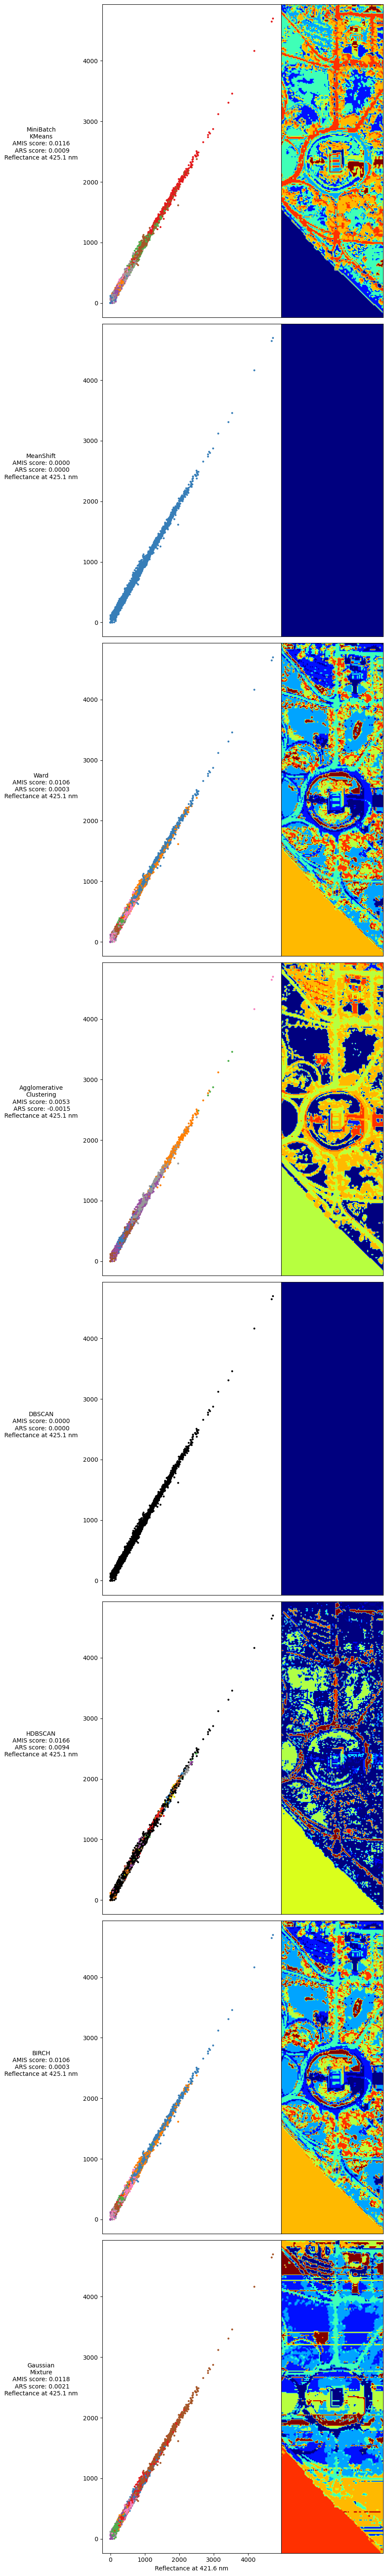

done with Polymer , MiniBatch
KMeans
done with Polymer , MeanShift
done with Polymer , Ward
done with Polymer , Agglomerative
Clustering
done with Polymer , DBSCAN


In [ ]:
import time

images = [('DC'
           ,'../spectral_images/WashingtonDC_Ref_156bands/WashingtonDC_Ref_156bands'
           ,'../spectral_images/WashingtonDC_groundTruth/WashDCclassLocations.txt'),
           ('Polymer'
           ,'../spectral_images/Microscene_Polymers/reflectance_image_polymers'
           ,'../spectral_images/Microscene_Polymers_groundTruth/reflectance_image_polymers_surfaces.txt')
           ]

#Instantiate empty lists
image = []
alg_list = []
amis_var = []
ars_var = []
tme = []
plot_num = 1
ncols = 100

#Define Clustering Algorithms
two_means = cluster.MiniBatchKMeans(n_clusters=8,random_state=0)
affinity_propagation = cluster.AffinityPropagation(random_state=0)
ms = cluster.MeanShift(bin_seeding=True)
spectral_cluster = cluster.SpectralClustering(n_clusters=8,random_state=0)
ward = cluster.AgglomerativeClustering(n_clusters=8, linkage="ward")
average_linkage = cluster.AgglomerativeClustering(n_clusters=8, linkage="average")
dbscan = cluster.DBSCAN(eps=3, min_samples=10)
hdbscan = cluster.HDBSCAN()
optics = cluster.OPTICS()
birch = cluster.Birch(n_clusters=8)
gmm = mixture.GaussianMixture(n_components=8,random_state=0)


clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means), #works on DC and Polymer (around 2 seconds)
        #("Affinity\nPropagation", affinity_propagation), #over 5 min on DC, kernal died on Polymer
        ("MeanShift", ms),#over 5 min on DC and Polymer
        #("Spectral\nClustering", spectral_cluster), #over 5 min on DC, kernal died on Polymer
        ("Ward", ward), #kernel died on DC, over 6 min on Polymer
        ("Agglomerative\nClustering", average_linkage), #over 5 min on DC and Polymer
        ("DBSCAN", dbscan), #works on DC (around 20 seconds), kernal died on Polymer
        ("HDBSCAN", hdbscan), #works on DC (5 min 17 sec) and Polymer (4 min 8 sec)
        #("OPTICS", optics), #over 6 min on DC and Polymer
        ("BIRCH", birch), ##kernel died on DC, works on Polymer (ran in like 2 seconds)
        ("Gaussian\nMixture", gmm), #ValueError: X has 156 features, but GaussianMixture is expecting 2 features as input.
    )




for i,j,k in images:
    #Data
    wl, im, imList = original_image(j)
    gt_list = ground_truth(k)

    #Sample
    nrows = im.ncols*ncols
    X = imList[:nrows,:im.nbands]

    #For Loop
    for name, algorithm  in clustering_algorithms:

        start_time = time.time()
        
        #Predicted Values for each Clusting Algorithm
        algorithm.fit(X)
        if hasattr(algorithm, "labels_"):
            yhat = algorithm.labels_.astype(int)
        else:
            yhat = algorithm.predict(X)
        print(f'done with {i} , {name}')
        
        t = time.time() - start_time


        #Evaluation Metrics
        amis = metrics.adjusted_mutual_info_score(yhat, gt_list[:nrows,])
        ars = metrics.adjusted_rand_score(yhat, gt_list[:nrows,])

        #Scatterplot
        #plt.figure(figsize=(10, 30), dpi=160)
        plt.subplot(len(clustering_algorithms), 2, plot_num)
        colors = np.array(list(islice(cycle(["#377eb8","#ff7f00","#4daf4a","#f781bf","#a65628","#984ea3","#999999","#e41a1c","#dede00",]),int(max(yhat) + 1),)))
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[yhat])
        plt.ylabel(f'{name}\nAMIS score: {amis:.4f}\n ARS score: {ars:.4f}\nReflectance at {wl[1]:.1f} nm', rotation=0, labelpad=70)#(f'{name}\nAMIS score: {amis:.4f}\n ARS score: {ars:.4f}', rotation=0, labelpad=50)
        plt.subplots_adjust(wspace = 0.1)

        if plot_num != ((len(clustering_algorithms)*2)-1):
            plt.xticks(())

        if plot_num == ((len(clustering_algorithms)*2)-1):
            plt.xlabel(f'Reflectance at {wl[0]:.1f} nm')

        plot_num += 1

        #Image
        plt.subplot(len(clustering_algorithms), 2, plot_num)
        class_image = np.reshape(yhat, (ncols, im.ncols))
        plt.imshow(np.flip(np.rot90(class_image), axis=0), cmap='jet')
        plt.gca().invert_yaxis()
        plt.xticks(())
        plt.yticks(())

        plot_num += 1

        tme.append(t)

        #Evaluation Metric Table
        image.append(i)
        amis_var.append(amis)
        ars_var.append(ars)
        alg_list.append(name)

    #Plot
    plt.gcf().set_size_inches(10, 60)#plt.figure(figsize=(60, 60), dpi=240)
    plt.tight_layout()
    plt.show()

    plot_num = 1


#Table
table = pd.DataFrame({'image':image, 'algorithm':alg_list, 'amis':amis_var, 'ars':ars_var, 'time (s)':tme})
print(table)

In [30]:
table.to_csv('table.csv', index = False)